In [4]:
import pandas as pd
import numpy as np
import requests
import json
import tweepy
import os
import re
import matplotlib.pyplot as plt

%matplotlib inline

# **Gathering Data**

### **Data provided from project resources**

In [5]:
twitarch_df = pd.read_csv('twitter-archive-enhanced-2.csv')

### **Data extracted through twitter API using tweepy**

In [6]:
# https://developer.twitter.com/en/docs/authentication/guides/authentication-best-practices
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")

# from http://docs.tweepy.org/en/latest/getting_started.html
# using Oauth 2
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
# https://knowledge.udacity.com/questions/66949#66975
api = tweepy.API(auth_handler = auth,
                 parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

```
Rate limit reached. Sleeping for: 607
Rate limit reached. Sleeping for: 606
```

### The code above ran for 32 minutes. I started execution at 14:30 on 2020-08-24 (Aug 24 2020). It finished around 15:02.

In [7]:
# get the info from json object that will be merged with original df
added_features = []
with open('tweet_json.txt', 'r') as file:
    for item in file:
        data = json.loads(item)
        added_features.append({'tweet_id': data['id'],
                               'favorite_count': data['favorite_count'],
                               'retweet_count': data['retweet_count']})
added_fields = pd.DataFrame(added_features)

### **Data extracted using the `requests` library**

### The project details gave 2 different URLs for the image predictions data. I will compare the 2 below.

In [8]:
# project gave us 2 different links. They are identical
!diff -s image_predictions.tsv image_predictions_2.tsv

Files image_predictions.tsv and image_predictions_2.tsv are identical


### Since the 2 image_predictions files are identical, I will use the file extracted from first URL.

In [9]:
imagepred_df = pd.read_csv('image_predictions.tsv', sep='\t')

-----------------------

# **Assessing Data**

## Visual Assessment (using libreoffice and emacs)
twitter-archive-enhanced-2.csv
- this file has 2357 rows including the row of column names
- this file has many blank cells, esp `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- `retweeted_status_id`, `retweeted_status_user_id` interpreted by libreoffice as floats
- `None` is in many cells in columns `doggo`, `floofer`, `pupper`, `puppo`
- some rows under column `text` contains the string "doggo" or "pupper", but `doggo` and `pupper` columns had `None`
- the dog stage column names `doggo`, `floofer`, `pupper`, `puppo` are values of dog stages (according to project details).
- since many cells in `rating_denominator` are 10, the rating is mostly likely based out of 10
- but there are some cells in `rating_denominator` that do NOT have 10
- there are some cells in `rating_numerator` that more than 10
- some cells in `name` have ordinary English words like "a" and some have what seem like "real" names
- the "real" names in `name` seem to be capitalized

image_predictions.tsv
- this file has fewer rows than twitter-archive-enhanced-2.csv
- some names are not capitalized in columns `p1`, `p2`, `p3`
- some column names are not sufficiently descriptive like `p1`, `p2`, `p3`

tweet_json.txt
- it is very hard to read with a text editor but it has 2331 lines
- this file has fewer rows than twitter-archive-enhanced-2.csv

## Programmatic Assessment

In [10]:
twitarch_df.info()
twitarch_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [29]:
twitarch_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [30]:
added_fields.info()
added_fields.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


,tweet_id,favorite_count,retweet_count
0,892420643555336193,35783,7568
1,892177421306343426,30896,5607
2,891815181378084864,23249,3714
3,891689557279858688,39055,7746
4,891327558926688256,37301,8346


In [12]:
added_fields.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7470.707422,2660.873016
std,6.823170e+16,11599.298490,4499.710811
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1300.000000,539.000000
50%,7.182469e+17,3247.000000,1244.000000
75%,7.986692e+17,9147.000000,3093.000000
max,8.924206e+17,154165.000000,76473.000000


In [13]:
imagepred_df.info()
imagepred_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [31]:
imagepred_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [15]:
# Are all the tweet_ids unique?
print(f"twitter archive: {twitarch_df.shape[0]} entries, {twitarch_df.tweet_id.nunique()} unique tweet_ids")
print(f"from twitter API: {added_fields.shape[0]} entries, {added_fields.tweet_id.nunique()} unique tweet_ids")
print(f"image prediction file: {imagepred_df.shape[0]} entries, {imagepred_df.tweet_id.nunique()} unique tweet_ids")

twitter archive: 2356 entries, 2356 unique tweet_ids
from twitter API: 2331 entries, 2331 unique tweet_ids
image prediction file: 2075 entries, 2075 unique tweet_ids


In [16]:
twitarch_df['text'].str.contains('doggo|pupper|puppo|floofer').sum()

399

In [17]:
# Does text contain information about dog stages while the dog stage columns have `None`
twitarch_df[twitarch_df['text'].str.contains('doggo|pupper|puppo|floofer') &
            (twitarch_df['doggo'] == 'None') & (twitarch_df['floofer'] == 'None') &
            (twitarch_df['pupper'] == 'None') & (twitarch_df['puppo'] == 'None')].count()[0]

41

In [18]:
# What are the values and the counts in the dog stage columns
print(twitarch_df.doggo.value_counts())
print(twitarch_df.floofer.value_counts())
print(twitarch_df.pupper.value_counts())
print(twitarch_df.puppo.value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [19]:
twitarch_df.name.nunique()

957

In [20]:
dog_name_df = twitarch_df.name.value_counts().to_frame()

In [21]:
dog_name_df.head()

,name
None,745
a,55
Charlie,12
Cooper,11
Lucy,11


The English word "a" is the most common name just after "None"

In [22]:
dog_name_df.sort_index(axis=0, inplace=True) # sorting by index which happens to be the names of dogs

In [23]:
dog_name_df.head() # sorted alphabetically

,name
Abby,2
Ace,1
Acro,1
Adele,1
Aiden,1


In [24]:
# the top names above are capitalized and the bottom 30 have a mixed of capitalized names then followed by lower-cased English words
dog_name_df.tail(30).index

Index(['Ziva', 'Zoe', 'Zoey', 'Zooey', 'Zuzu', 'a', 'actually', 'all', 'an',
       'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life',
       'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite',
       'space', 'such', 'the', 'this', 'unacceptable', 'very'],
      dtype='object')

In [35]:
# according to project details drop "no retweets" when it comes to original ratings
twitarch_df[twitarch_df.retweeted_status_id.notnull()].count()[0]

181

#### **Quality**

##### `twitarch_df` table from file `twitter-archive-enhanced-2.csv`
- the columns `doggo`, `floofer`, `pupper`, `puppo` are mostly the string "None".
- some rows under column `text` contain string "doggo" or "pupper", but `doggo` and `pupper` columns had `None`
- the `name` column has normal English words like "a", "the", "this"
- the "real" dog names are capitalized, the rest are in lower case
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` are mostly `NaN`
- both the `rating_numerator` and `rating_denominator` have some outliers, 1776 and 170 respectively
- `expanded_urls` has missing data
- there are retweets mixed in data. According to project details, they are not used

##### `added_fields` table from file `tweet_json.txt`
- table has 2331 entries. It has fewer entries than the table `twitarch_df`
- some `favorite_count` has 0 entries.

##### `imagepred_df` table from file `image_predictions.tsv`
- table has 2075 entries. It has fewer entries than the table `twitarch_df`
- there are capitalization issues in entries under `p1`, `p2`, `p3`
- there are high confidence numbers for `p1` but has `False` under `p1_dog`.
- but has `True` in `p2_dog` or `p3_dog`

#### **Tidiness**

##### `twitarch_df` table
- the columns `doggo`, `floofer`, `pupper`, `puppo` are dog stage values
- `timestamp` and `retweeted_status_timestamp` are not datetime type
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` are type `float64`, and not `int64`

##### `added_fields` table
- no structural issues found

##### `imagepred_df` table
- many column names like `p1`, `p2`, `p3` are not descriptive
- `p1`, `p1_conf`, `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog` have extraneous information. They can be conflated into 2 variables

--------------------------------
# **Cleaning Data**

In [36]:
# make copies
twitarch_work = twitarch_df.copy()
imagepred_work = imagepred_df.copy()
addedfields_work = added_fields.copy()

In [420]:
#twitarch_work.set_index('tweet_id')
#twitarch_work.head(3)
dog_stage = ['doggo', 'floofer', 'pupper', 'puppo']

In [421]:
#temp = twitarch_work[dog_stage]

In [422]:
#twitarch_work.replace(to_replace={'None': None}, value=None, method=None, inplace=True)
for ds in dog_stage:
    twitarch_work[ds].replace({'None': np.nan}, inplace=True)

In [423]:
twitarch_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       97 no

In [167]:
#temp[dog_stage].notnull().sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [424]:
# create a new column that sums by row the dog_stages
twitarch_work['ds_sum'] = twitarch_work[dog_stage].notnull().sum(axis=1)

In [425]:
twitarch_work[dog_stage + ['ds_sum']].head()

,doggo,floofer,pupper,puppo,ds_sum
0,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,0


In [426]:
#twitarch_work[twitarch_work.ds_sum > 1].count()

In [427]:
# get all the indices of specific dog stages, then write into cell the dog stage
for ds in dog_stage:
    tidx = twitarch_work[(twitarch_work.text.str.contains(ds, case=False)) & (twitarch_work['ds_sum'] == 0)].index
    # for all the indices found for that dog stage, write the dog stage
    twitarch_work.loc[tidx, ds] = ds

In [428]:
# do the same as creation of the column ds_sum above but this time accounting for the recent additions just above
twitarch_work['ds_sum'] = twitarch_work[dog_stage].notnull().sum(axis=1) # sum the 4 dog_stage

In [429]:
#twitarch_work.to_csv('twitarch_work.csv', index=False)

In [430]:
# verify that text containing a dog stage are accounted for
twitarch_work[(twitarch_work.text.str.contains('doggo|pupper|puppo|floofer', case=False)) & (twitarch_work['ds_sum'] == 0)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ds_sum


In [431]:
ds_counts = []
for ds in dog_stage:
    ds_counts.append(twitarch_work[ds].value_counts()[0])
ds_counts

[107, 10, 283, 37]

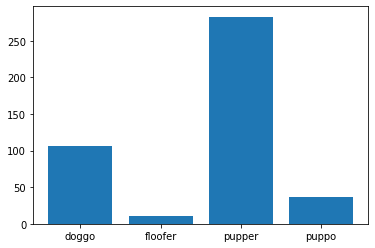

In [432]:
# Let us see a quick visual of frequency of dog stages. It did not matter to me if some tweets had content in more than one dog stage



plt.bar(dog_stage, ds_counts);

In [433]:
# create a new column to combine content from the 4 columns of dog stages
combo_idx = twitarch_work[twitarch_work.ds_sum > 1].index
# casting was more complicated than usual. I got help from: https://stackoverflow.com/questions/60529588/how-can-i-cast-a-pandas-string-column-to-the-new-nullable-int64-type
twitarch_work['dog_stage'] = twitarch_work['doggo'].fillna('').map(str) + twitarch_work['floofer'].fillna('').map(str) + twitarch_work['pupper'].fillna('').map(str) + twitarch_work['puppo'].fillna('').map(str)
# prefix the multiple dog stages with "combo"
twitarch_work.loc[combo_idx, 'dog_stage'] = 'combo-' + twitarch_work['dog_stage']
#twitarch_work[twitarch_work.ds_sum == 0].loc['dog_stage'] = 'None'
twitarch_work['dog_stage'].replace({'': 'None'}, inplace=True)

In [434]:
twitarch_work.dog_stage.value_counts()

None                  1933
pupper                 271
doggo                   93
puppo                   36
combo-doggopupper       12
floofer                  9
combo-doggopuppo         1
combo-doggofloofer       1
Name: dog_stage, dtype: int64

In [435]:
twitarch_work.to_csv('twitarch_work.csv', index=False)

### Clean dog names

### It seems that all the "real" names of the dogs are capitalized. The non-capitalized names are most likely accidental entries.

In [442]:
twitarch_work['name'].replace(to_replace=r'^[a-z]+', value='None', regex=True, inplace=True)
#twitarch_work['name'].replace({'a': 'None'}, inplace=True)

In [443]:
xtm2 = twitarch_work['name'].value_counts()

In [444]:
xtm2_df = xtm2.to_frame()

In [445]:
xtm2_df.sort_index(axis=0, inplace=True)
xtm2_df.tail(30)

,name
Walker,1
Wallace,3
Wally,2
Walter,4
Watson,2
Wesley,1
Wiggles,1
Willem,1
William,1
Willie,1


In [446]:
twitarch_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       107 n

### clean timestamp

In [449]:
#pd.to_datetime(twitarch_work['timestamp']) #twitarch_work['Date']
# source: https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
twitarch_work['timestamp'] = twitarch_work.timestamp.astype('datetime64[ns]')

In [450]:
twitarch_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

### clean expanded_urls
#### I have absolutely no idea what expanded_urls are but visually it looks like that there could be a url with this form: https://twitter.com/dog_rates/status/tweet_id.

In [467]:
# created a new column that is a string copy of the tweet_id in order for me to concatenate the strings in expanded_urls
# twitarch_work['tweet_id_str'] = twitarch_work.tweet_id.astype('str')
twitarch_work.expanded_urls.fillna('https://twitter.com/dog_rates/status/' + twitarch_work['tweet_id_str'], inplace=True)

In [468]:
twitarch_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

## clean rating_numerator and rating_denominator

In [473]:
twitarch_work['rating_denominator'][twitarch_work.rating_denominator != 10].count()

23

### There are only 23 rows that rating denominator is not 10. I will handle each case with regular expressions

In [474]:
zzz = twitarch_work[twitarch_work.rating_denominator != 10]
zzz

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ds_sum,dog_stage,tweet_id_str
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,https://twitter.com/dog_rates/status/835246439529840640,960,0,None,NaN,NaN,NaN,NaN,0,None,835246439529840640
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832088576586297345,11,15,None,NaN,NaN,NaN,NaN,0,None,832088576586297345
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,NaN,NaN,NaN,NaN,0,None,820690176645140481
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,NaN,NaN,NaN,NaN,0,None,810984652412424192
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,NaN,NaN,NaN,NaN,0,None,775096608509886464
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,NaN,NaN,NaN,NaN,0,None,758467244762497024
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,NaN,NaN,NaN,NaN,0,None,740373189193256964
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,None,doggo,NaN,NaN,NaN,1,doggo,731156023742988288
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47,"<a href=""http://

In [476]:
zzz.to_csv('denominator.csv', index=True)

In [477]:
zzz.index

Int64Index([ 313,  342,  433,  516,  784,  902, 1068, 1120, 1165, 1202, 1228,
            1254, 1274, 1351, 1433, 1598, 1634, 1635, 1662, 1663, 1779, 1843,
            2335],
           dtype='int64')

### I could do the easy way and just give the median as the numerator and 10 as the denominator. But I will do it the hard way first with regular expressions: first find in text of any possible rating, then extract

In [497]:
import re

In [519]:
pat = re.compile('(\d+)\/10') # find in text if there is ##/10
pat2 = re.compile('(\d+)\/(\d+)\D+\D') # find if there is anynumber/anynumber

In [524]:
# regular expression
for idx in zzz.index:
    string = twitarch_work.loc[idx, 'text']
    rate = pat.search(string)
    rate2 = pat2.search(string)
    if rate:
        numerator = rate.groups()[0]
    elif rate2:
        #numerator = rate2.groups()
        numerator = int(rate2.groups()[0]) * 10 / int(rate2.groups()[1])
    else:
        numerator = twitarch_work.rating_numerator.median() # I am giving this the median score as shown in describe

    twitarch_work.loc[idx, 'rating_numerator'] = int(numerator)
    twitarch_work.loc[idx, 'rating_denominator'] = 10

In [525]:
twitarch_work['rating_denominator'][twitarch_work.rating_denominator != 10].count()

0

In [526]:
twitarch_work.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,ds_sum
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.0,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,12.230475,10.0,0.185484
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,40.825702,0.0,0.403774
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,10.0,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.0,0.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.0,0.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.0,0.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,10.0,2.000000


In [532]:
twitarch_work.rating_numerator.median()

11.0

In [533]:
twitarch_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

## Clean data from JSON file extracted through twitter's API

In [534]:
json_work = added_fields.copy()

In [535]:
json_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [536]:
json_work.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7470.707422,2660.873016
std,6.823170e+16,11599.298490,4499.710811
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1300.000000,539.000000
50%,7.182469e+17,3247.000000,1244.000000
75%,7.986692e+17,9147.000000,3093.000000
max,8.924206e+17,154165.000000,76473.000000


In [537]:
twitarch_clean = pd.merge(twitarch_work, json_work, on=['tweet_id'], how='left')

In [538]:
twitarch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [539]:
twitarch_clean.head(30)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,name,doggo,floofer,pupper,puppo,ds_sum,dog_stage,tweet_id_str,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,Phineas,NaN,NaN,NaN,NaN,0,None,892420643555336193,35783.0,7568.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,Tilly,NaN,NaN,NaN,NaN,0,None,892177421306343426,30896.0,5607.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,Archie,NaN,NaN,NaN,NaN,0,None,891815181378084864,23249.0,3714.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,Darla,NaN,NaN,NaN,NaN,0,None,891689557279858688,39055.0,7746.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,Franklin,NaN,NaN,NaN,NaN,0,None,891327558926688256,37301.0,8346.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,...,None,NaN,NaN,NaN,NaN,0,None,891087950875897856,18803.0,2800.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",...,Jax,NaN,NaN,NaN,NaN,0,None,890971913173991426,10920.0,1820.0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",...,None,NaN,NaN,NaN,NaN,0,None,890729181411237888,60258.0,16934.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey.

In [542]:
clean_df = twitarch_clean.copy()

In [543]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

###  There is a discrepancy of 25 between the number of `tweet_id`s. The accounting is below

In [559]:
clean_df[clean_df.retweeted_status_id.notnull() & ((clean_df.retweet_count.isnull()) | (clean_df.favorite_count.isnull()))].count()['tweet_id']

18

## need to drop these retweets with null favorite and retweet counts, and they need to be dropped anyway
### In the meantime, I will put zero in their those columns

**When I extracted the JSON file through twitter API, I also collected `tweet_id`s that did not have any info.**

In [550]:
no_info_ids = pd.read_csv('no_info_ids.txt')

In [551]:
no_info_ids.head()

,tweet_id
0,888202515573088257
1,873697596434513921
2,872668790621863937
3,872261713294495745
4,869988702071779329


In [552]:
no_info_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  25 non-null     int64
dtypes: int64(1)
memory usage: 328.0 bytes


In [556]:
no_info_lst = no_info_ids.tweet_id.to_list()

In [561]:
clean_df[clean_df.retweeted_status_id.isnull() & clean_df.tweet_id.isin(no_info_lst)].count()['tweet_id']

7

**18 retweets and 7 tweet_id with missing info from twitter data. I will put zeroes in those fields**

In [562]:
clean_df.favorite_count.fillna(0, inplace=True)
clean_df.retweet_count.fillna(0, inplace=True)

In [563]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

## Clean image prediction frame

In [617]:
imagepred_work = imagepred_df.copy()

In [618]:
imagepred_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [658]:
pred_cols = imagepred_work.columns.tolist()

In [659]:
imagepred_work.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [660]:
pred_cols.pop(0) # delete tweet_id from list

'tweet_id'

In [661]:
na_dict = dict(zip(pred_cols, ['None', 0, 'None', 0.0, False, 'None', 0.0, False, 'None', 0.0, False]))

In [662]:
na_dict

{'jpg_url': 'None',
 'img_num': 0,
 'p1': 'None',
 'p1_conf': 0.0,
 'p1_dog': False,
 'p2': 'None',
 'p2_conf': 0.0,
 'p2_dog': False,
 'p3': 'None',
 'p3_conf': 0.0,
 'p3_dog': False}

In [663]:
pred_df = pd.merge(clean_df, imagepred_work, on=['tweet_id'], how='left')

In [664]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [665]:
pred_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

## completeness

In [666]:
# declaratively replace all the nulls in colums specified in na_dict with the values
for key, val in na_dict.items():
    pred_df[key].fillna(val, inplace=True)

In [667]:
pred_df['p1_dog'] = pred_df.p1_dog.astype('bool')
pred_df['p2_dog'] = pred_df.p2_dog.astype('bool')
pred_df['p3_dog'] = pred_df.p3_dog.astype('bool')

In [668]:
pred_df.p1_dog.value_counts()

True     1532
False     824
Name: p1_dog, dtype: int64

In [669]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [670]:
# consistency in capitalization
pred_df['p1'] = pred_df['p1'].str.lower()
pred_df['p2'] = pred_df['p2'].str.lower()
pred_df['p3'] = pred_df['p3'].str.lower()

In [672]:
pred_df['is_dog'] = 0
pred_df['is_dog'] = pred_df[['p1_dog', 'p2_dog', 'p3_dog']].sum(axis=1)

In [674]:
pred_df[pred_cols+['is_dog']].head()

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog
0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,0
1,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,3
2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3
3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,1
4,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,3


In [675]:
# I will create a new column called dog_breed. If p1_dog is True, dog breed will be p1
#pred_df['is_dog'][pred_df.is_dog == 0] = 'None'
pred_df['dog_breed'] = np.nan
pred_df['dog_breed'] = np.where(pred_df['is_dog'] == 3, pred_df['p1'], np.nan)

In [676]:
pred_df[['tweet_id'] + pred_cols + ['is_dog','dog_breed']].head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog,dog_breed
0,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,0,NaN
1,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,3,chihuahua
2,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3,chihuahua
3,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,1,NaN
4,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,3,basset
5,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False,2,NaN
6,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False,2,NaN
7,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True,3,pomeranian
8,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True,3,irish_terrier
9,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True,3,pembroke


In [677]:
# find all the indices 
p2_idx = pred_df[pred_df.dog_breed.isnull() & pred_df.p2_dog].index
pred_df.loc[p2_idx, 'dog_breed'] = pred_df['p2']

In [678]:
p3_idx = pred_df[pred_df.dog_breed.isnull() & pred_df.p3_dog].index
pred_df.loc[p3_idx, 'dog_breed'] = pred_df['p3']

In [679]:
pred_df[['tweet_id'] + pred_cols + ['is_dog','dog_breed']].head(60)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog,dog_breed
0,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,0,NaN
1,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,3,chihuahua
2,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3,chihuahua
3,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,1,labrador_retriever
4,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,3,basset
5,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False,2,irish_terrier
6,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False,2,border_collie
7,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True,3,pomeranian
8,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True,3,irish_terrier
9,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True,3,pembroke


In [685]:
pred_df.dog_breed.isnull().sum()

648

In [686]:
pred_df.dog_breed.fillna('None', inplace=True)

In [687]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [717]:
breeds = pred_df.dog_breed.value_counts().rename_axis('breed').reset_index(name='freq')

In [718]:
breeds.drop(0, axis=0, inplace=True) # drop the None breed

In [719]:
breeds.head()

,breed,freq
1,golden_retriever,171
2,labrador_retriever,113
3,pembroke,91
4,chihuahua,71
5,pug,58


In [735]:
#pred_df[pred_df.retweeted_status_id.notnull()].count()['tweet_id']
pred_df[pred_df.retweeted_status_id.notnull()].count()['tweet_id']

181

In [736]:
# eliminate lines that are retweets
pred_df.drop(pred_df[pred_df.retweeted_status_id.notnull()].index, axis=0, inplace=True)

In [737]:
pred_df[pred_df.retweeted_status_id.notnull()].count()['tweet_id']

0

In [738]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2175 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2175 non-null   datetime64[ns]
 4   source                      2175 non-null   object        
 5   text                        2175 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2175 non-null   object        
 10  rating_numerator            2175 non-null   int64         
 11  rating_denominator          2175 non-null   int64       